In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal
import lib.io.stan
import numpy as np

In [2]:
np.random.seed(0)
ntwrk = np.load('datasets/id001_ac/AC_network.npz')
SC = ntwrk['SC']
gain = ntwrk['gain_mat']
sim_data_6d = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')

nn = SC.shape[0]
ns  = gain.shape[0]
nt = 10000
I1 = 3.1
tau0 = 2857.0
x0 = sim_data_6d['x0']
time_scale = 0.8
time_step = 0.5
nsteps = int(1/time_step)
sigma = 0.0
k = 1.0
epsilon = 0.01
x_init = -1.8*np.ones(nn)
z_init = 3.5*np.ones(nn)
z_eta = np.random.normal(size = (nt, nn))

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 'gain':gain,
        'x0':x0, 'time_scale':time_scale, 'time_step':time_step, 'nsteps': nsteps,
        'sigma':sigma, 'k':k, 'epsilon':epsilon, 'x_init':x_init, 'z_init':z_init,
        'z_eta':z_eta}

lib.io.stan.rdump('./tmp/tmp.R',data)

! /home/anirudhnihalani/scripts/stancompile.sh vep-forwardsim-2Depileptor

! srun -p dev --ntasks=1 ./vep-forwardsim-2Depileptor sample num_warmup=0 \
num_samples=1 algorithm=fixed_param data file='tmp/tmp.R' output file='tmp/tmp.csv'

/home/anirudhnihalani/vep.stan
make: `/home/anirudhnihalani/vep.stan/vep-forwardsim-2Depileptor' is up to date.
srun: job 657920 queued and waiting for resources
srun: error: Lookup failed: Unknown host
srun: job 657920 has been allocated resources
method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = tmp/tmp.R
init = 2 (Default)
random
  seed = 91978790
output
  file = tmp/tmp.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               4.2 seconds (Sampling)
               4.2 seconds (Total)



In [3]:
sim_out = lib.io.stan.read_samples('tmp/tmp.csv',0,1,ignore_warmup=True)
syn_data = np.load('datasets/id001_ac/AC_fit_trgt.npz')

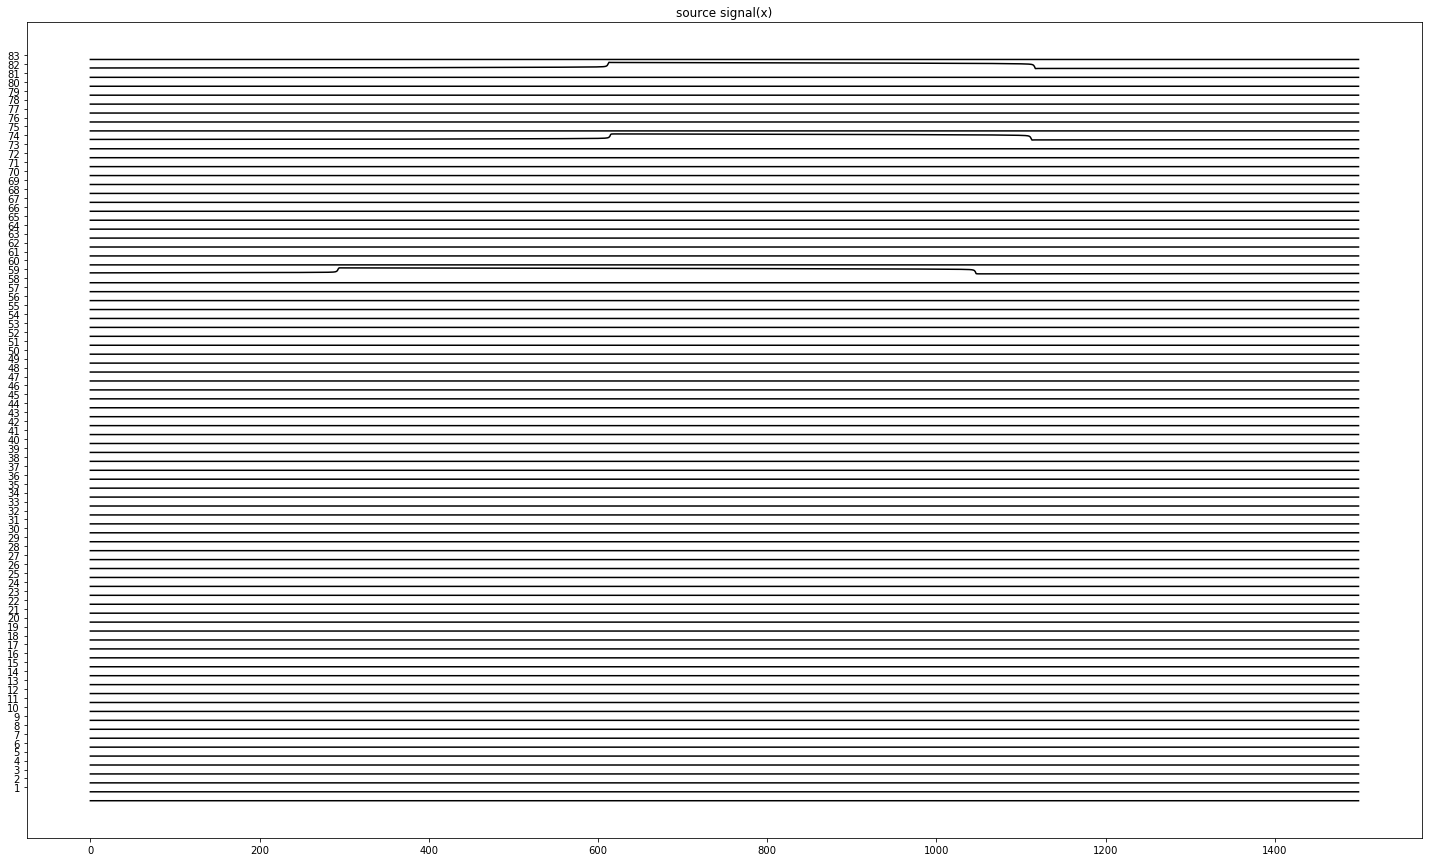

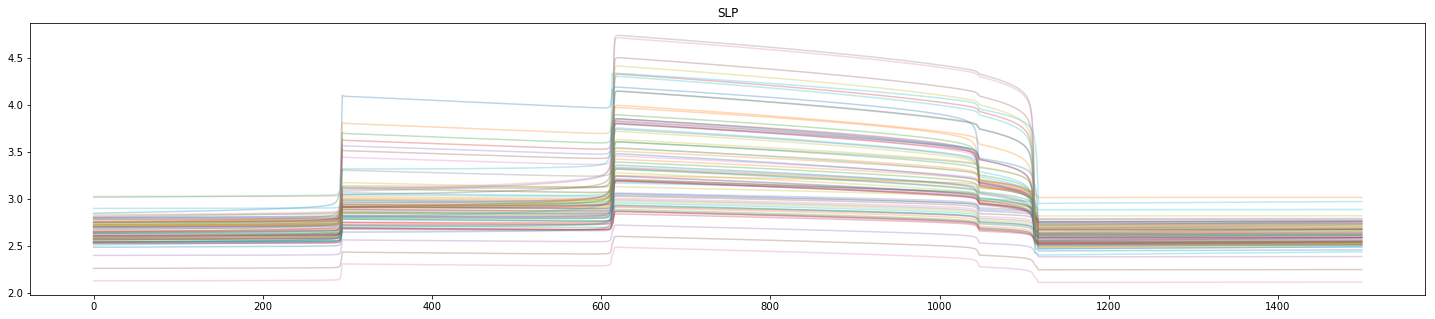

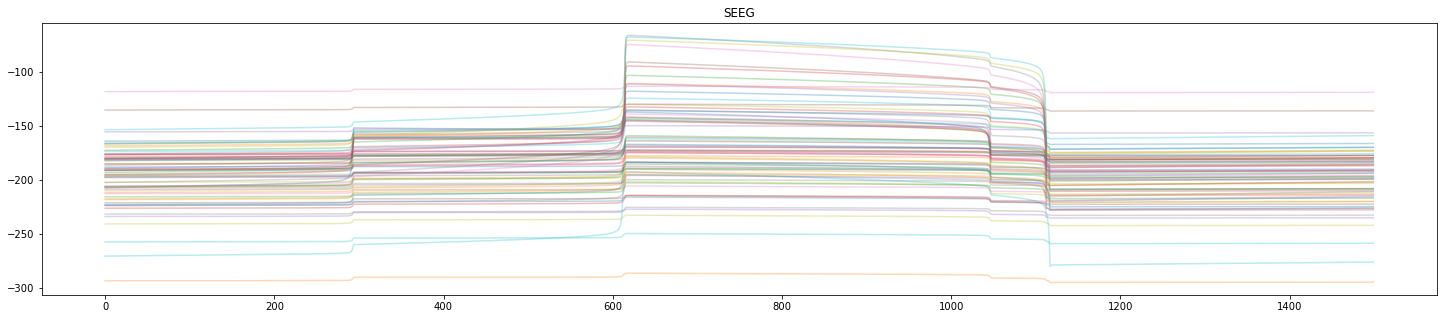

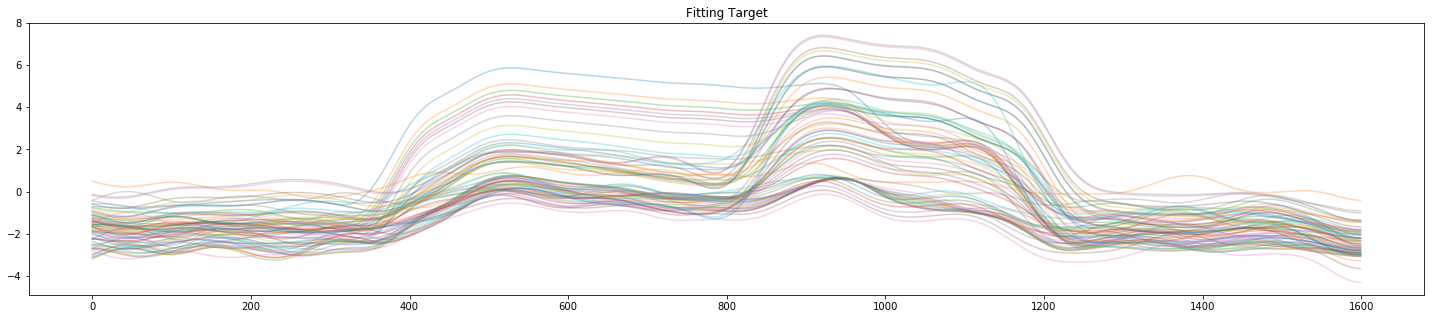

In [4]:
start_idx = 4950
end_idx = start_idx + 1500

plt.figure(figsize=(25,15))
plt.plot(sim_out['x'][0,start_idx:end_idx,:]/4.0 + np.r_[0:nn],'k');
plt.yticks(np.r_[1:nn], np.r_[1:nn])
plt.title('source signal(x)')

plt.figure(figsize=(25,5))
plt.plot(sim_out['slp'][0,start_idx:end_idx,:],alpha=0.3);
plt.title('SLP')

plt.figure(figsize=(25,5))
plt.plot(sim_out['seeg'][0,start_idx:end_idx,:],alpha=0.3);
plt.title('SEEG')

plt.figure(figsize=(25,5))
plt.plot(syn_data['fit_trgt'],alpha=0.3);
plt.title('Fitting Target')
